In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from pycocotools.coco import COCO
from segment_anything import sam_model_registry as sam_model_registry_lora
from segment_anything_new import SamPredictor, sam_model_registry
from segment_anything_new.utils.transforms import ResizeLongestSide
from SurfaceDice import compute_dice_coefficient
from pathlib import Path
# set seeds
torch.manual_seed(1234)
np.random.seed(1234)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#%% compare the segmentation results between the original SAM model and the fine-tuned model
# load the original SAM model
# from skimage import io
import random
ori_sam_model= sam_model_registry['vit_b'](checkpoint=r"D:\Side_project\SAMed\MedSAM\medsam_vit_b.pth")

ori_sam_model.to(device)

ori_sam_predictor = SamPredictor(ori_sam_model)

# rand_id = 146
root_dir = Path(r'D:\Side_project\SAMed\data\map_1-1_gastrointestinal_coco\valid')

# rand_id = random.randint(0, len(list(root_dir.glob('*.jpg')))-1)
rand_id = 5



anno_info = COCO(r'D:\Side_project\SAMed\data\map_1-1_gastrointestinal_coco\valid\_annotations.coco.json')
image_info = anno_info.loadImgs(rand_id)[0]
image_path = root_dir / image_info['file_name']
ann_ids = anno_info.getAnnIds(imgIds=rand_id)
anns = anno_info.loadAnns(ann_ids)

mask = anno_info.annToMask(anns[0])
# print(mask)
# for ann in anns:
#     mask = anno_info.annToMask(ann)
#     masks.append(mask)

# random select a test case
# img_idx = np.random.randint(len(test_names))
image_data = np.array(Image.open(root_dir / image_info['file_name']))
# if image_data.shape[-1]>3 and len(image_data.shape)==3:
#     image_data = image_data[:,:,:3]
# if len(image_data.shape)==2:
#     image_data = np.repeat(image_data[:,:,None], 3, axis=-1)
# read ground truth (gt should have the same name as the image) and simulate a bounding box
def get_bbox_from_mask(mask):
    '''Returns a bounding box from a mask'''
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = mask.shape
    x_min = max(1, x_min - np.random.randint(0, 20))
    x_max = min(W-1, x_max + np.random.randint(0, 20))
    y_min = max(1, y_min - np.random.randint(0, 20))
    y_max = min(H-1, y_max + np.random.randint(0, 20))

    return np.array([x_min, y_min, x_max, y_max])

# gt_data = io.imread(join(ts_gt_path, test_names[img_idx]))
bbox_raw = get_bbox_from_mask(mask)
print(f'{bbox_raw=}')


# # preprocess: cut-off and max-min normalization
lower_bound, upper_bound = np.percentile(image_data, 0.5), np.percentile(image_data, 99.5)
image_data_pre = np.clip(image_data, lower_bound, upper_bound)
image_data_pre = (image_data_pre - np.min(image_data_pre))/(np.max(image_data_pre)-np.min(image_data_pre))*255.0
image_data_pre[image_data==0] = 0
image_data_pre = np.uint8(image_data_pre)
H, W, _ = image_data_pre.shape

# predict the segmentation mask using the original SAM model
ori_sam_predictor.set_image(image_data_pre)
ori_sam_seg, _, _ = ori_sam_predictor.predict(point_coords=None, box=bbox_raw, multimask_output=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
bbox_raw=array([ 14, 145,  60, 177], dtype=int64)


In [4]:
# predict the segmentation mask using the fine-tuned model
# resize image to 3*1024*1024
checkpoint_gas = r'D:\Side_project\MedSAM\work_dir\demo2D_ICIP\sam_model_best.pth'
sam_model= sam_model_registry['vit_b'](checkpoint=checkpoint_gas)

sam_model.to(device)

sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
resize_img = sam_transform.apply_image(image_data_pre)
# print(resize_img.shape)
# plt.imshow(resize_img)

resize_img_tensor = transforms.ToTensor()(resize_img).to(device)
# print(resize_img_tensor.shape)
# resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)

input_image = sam_model.preprocess(resize_img_tensor.unsqueeze(dim=0)) # (1, 3, 1024, 1024)
# assert input_image.shape == (1, 3, sam_model.image_encoder.img_size, sam_model.image_encoder.img_size), 'input image should be resized to 1024*1024'

with torch.no_grad():
    # pre-compute the image embedding
    ts_img_embedding = sam_model.image_encoder(input_image)
    # convert box to 1024x1024 grid
    bbox = sam_transform.apply_boxes(bbox_raw, (H, W))
    print(f'{bbox_raw=} -> {bbox=}')
    box_torch = torch.as_tensor(bbox, dtype=torch.float, device=device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 4) -> (B, 1, 4)
    
    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    medsam_seg_prob, _ = sam_model.mask_decoder(
        image_embeddings=ts_img_embedding.to(device), # (B, 256, 64, 64)
        image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )
    medsam_seg_prob = torch.sigmoid(medsam_seg_prob)

    pred_shapped_masks = F.interpolate(
        medsam_seg_prob, # shape: (1, 1, 256, 256)
        (224, 224),
        mode="bilinear",
        align_corners=False,
    )

    # convert soft mask to hard mask
    pred_shapped_masks = pred_shapped_masks.cpu().numpy().squeeze()
    medsam_seg = (pred_shapped_masks > 0.5).astype(np.uint8)

bbox_raw=array([ 14, 145,  60, 177], dtype=int64) -> bbox=array([[ 64, 662, 274, 809]], dtype=int64)


In [5]:
from importlib import import_module

checkpoint_sam = r'D:\Side_project\SAMed\MedSAM\medsam_vit_b.pth'
checkpoint_lora = r'D:\Side_project\SAMed\output\MedSAM\results\gastrointestinal_512_pretrain_vit_b_epo200_bs5_lr0.0001\best_epoch=102_valid_loss=0.068.pth'
sam_model, _ = sam_model_registry_lora['vit_b'](image_size=512, 
                                            num_classes=2,
                                            checkpoint=checkpoint_sam, 
                                            pixel_mean=[0, 0, 0],
                                            pixel_std=[1, 1, 1])

sam_model.to(device)

pkg = import_module('sam_lora_image_encoder')
net = pkg.LoRA_Sam(sam_model, 4).cuda()
net.load_lora_parameters(checkpoint_lora)

In [6]:
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize(size=(512,512)),
                                transforms.ToTensor()])
img_tensor = transform(image_data_pre)
img_tensor = img_tensor.unsqueeze(dim=0).to(device)
img_tensor.shape

torch.Size([1, 3, 512, 512])

In [7]:
with torch.no_grad():
    output = net(img_tensor, False, 512)
output['masks'].shape

torch.Size([1, 3, 512, 512])

In [8]:
transform = transforms.Compose([transforms.Resize(size=(224,224))])

output_masks = torch.argmax(torch.softmax(output['masks'], dim=1), dim=1, keepdim=True)
output_masks = output_masks.squeeze(dim=0) * 50
output_masks = transform(output_masks)
output_masks_np_lora = output_masks.cpu().numpy()
output_masks_np_lora = (output_masks_np_lora > 0).astype(np.uint8)
output_masks_np_lora.shape

(1, 224, 224)

In [9]:
ori_sam_dsc = compute_dice_coefficient(mask>0, ori_sam_seg>0)
medsam_dsc = compute_dice_coefficient(mask>0, medsam_seg>0)
sam_lora_dsc = compute_dice_coefficient(mask>0, output_masks_np_lora>0)
print(f'Original SAM DSC: {ori_sam_dsc:.4f} MedSAM DSC: {medsam_dsc:.4f}, MedSAM LoRA DSC: {sam_lora_dsc:.4f}')

Original SAM DSC: 0.4274 MedSAM DSC: 0.3971, MedSAM LoRA DSC: 0.0000


mask.shape=(224, 224)
h=224, w=224
mask.shape=(1, 224, 224)
h=224, w=224
mask.shape=(224, 224)
h=224, w=224
mask.shape=(1, 224, 224)
h=224, w=224


(-0.5, 223.5, 223.5, -0.5)

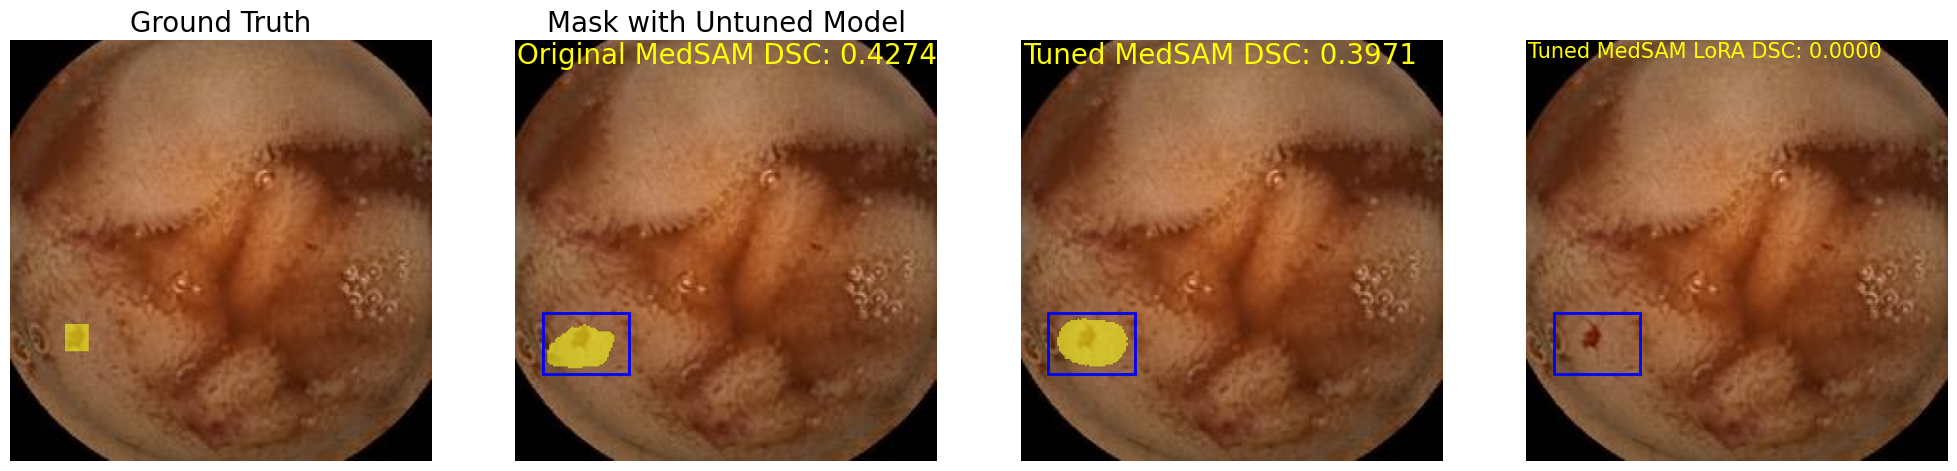

In [10]:
def show_mask(mask, ax, random_color=False):
    
    print(f'{mask.shape=}')
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    print(f'{h=}, {w=}')
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))    

_, axs = plt.subplots(1, 4, figsize=(25, 25))
axs[0].imshow(image_data)
show_mask(mask>0, axs[0])
# show_box(box_np[img_id], axs[0])
# axs[0].set_title('Mask with Tuned Model', fontsize=20)
axs[0].set_title('Ground Truth', fontsize=20)
axs[0].axis('off')

axs[1].imshow(image_data)
show_mask(ori_sam_seg, axs[1])
show_box(bbox_raw, axs[1])
# # add text to image to show dice score
axs[1].text(0.5, 0.5, 'Original MedSAM DSC: {:.4f}'.format(ori_sam_dsc), fontsize=20, horizontalalignment='left', verticalalignment='top', color='yellow')
axs[1].set_title('Mask with Untuned Model', fontsize=20)
axs[1].axis('off')

axs[2].imshow(image_data)
show_mask(medsam_seg, axs[2])
show_box(bbox_raw, axs[2])
axs[2].text(0.5, 0.5, 'Tuned MedSAM DSC: {:.4f}'.format(medsam_dsc), fontsize=20, horizontalalignment='left', verticalalignment='top', color='yellow')
axs[2].axis('off')

axs[3].imshow(image_data)
show_mask(output_masks_np_lora, axs[3])
show_box(bbox_raw, axs[3])
axs[3].text(0.5, 0.5, 'Tuned MedSAM LoRA DSC: {:.4f}'.format(sam_lora_dsc), fontsize=15, horizontalalignment='left', verticalalignment='top', color='yellow')
axs[3].axis('off')